In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D #convolution layers
from tensorflow.keras.layers import Dense, Dropout, Flatten #core layers
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.datasets import mnist

print('all imports are go!!')

Using TensorFlow backend.


all imports are go!!


In [2]:
train = pd.read_csv('train.csv')
train.shape

(42000, 785)

In [3]:
X = train.drop(['label'], 1).values
y = train['label'].values
X.shape

(42000, 784)

In [4]:
y.shape

(42000,)

##### Grayscale normalization
###### CNN converg faster on [0..1] than on [0..255]

In [5]:
X = X / 255.0

In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X = X.reshape(-1, 28, 28, 1)

In [7]:
# one hot encode labels using keras, to_categorical method
y = to_categorical(y)
y.shape

(42000, 10)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

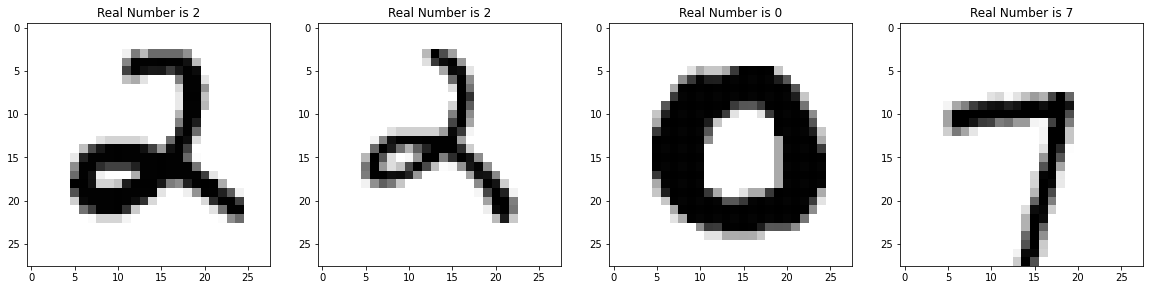

In [10]:
X_train__ = X_train.reshape(X_train.shape[0], 28, 28)

fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real Number is {digit}");

In [11]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std

# CNN

In [12]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(10,activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [14]:
# fit original data without the generated data
model.fit(X, y, batch_size=128, validation_split=0.2, epochs=5)

Epoch 1/5
263/263 [==============================] - 647s 2s/step - loss: 0.1009 - accuracy: 0.9696 - val_loss: 3.9245 - val_accuracy: 0.1367
Epoch 2/5
263/263 [==============================] - 606s 2s/step - loss: 0.0363 - accuracy: 0.9889 - val_loss: 0.3960 - val_accuracy: 0.8782
Epoch 3/5
263/263 [==============================] - 604s 2s/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 0.0357 - val_accuracy: 0.9901
Epoch 4/5
263/263 [==============================] - 670s 3s/step - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.0433 - val_accuracy: 0.9910
Epoch 5/5
263/263 [==============================] - 603s 2s/step - loss: 0.0174 - accuracy: 0.9947 - val_loss: 0.0448 - val_accuracy: 0.9904


# Data augmentation

In [15]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=128)
test_gen = datagen.flow(X_test, y_test, batch_size=128)

In [16]:
epochs = 10
batch_size = 128
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metric to monitor
        patience=3, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )
rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [17]:
# Fit the model with additional generated data
history = model.fit(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/10
295/295 [==============================] - 794s 3s/step - loss: 0.0817 - accuracy: 0.9759 - val_loss: 0.0718 - val_accuracy: 0.9753
Epoch 2/10
295/295 [==============================] - 767s 3s/step - loss: 0.0450 - accuracy: 0.9864 - val_loss: 0.0445 - val_accuracy: 0.9844
Epoch 3/10
295/295 [==============================] - 702s 2s/step - loss: 0.0396 - accuracy: 0.9880 - val_loss: 0.0466 - val_accuracy: 0.9863
Epoch 4/10
295/295 [==============================] - 573s 2s/step - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0530 - val_accuracy: 0.9817
Epoch 5/10
295/295 [==============================] - 488s 2s/step - loss: 0.0313 - accuracy: 0.9905 - val_loss: 0.0372 - val_accuracy: 0.9885
Epoch 6/10
295/295 [==============================] - 441s 1s/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0291 - val_accuracy: 0.9905
Epoch 7/10
295/295 [==============================] - 435s 1s/step - loss: 0.0274 - accuracy: 0.9915 - val_loss: 0.0327 - val_accuracy: 0.9895

In [29]:
# plot the model
plot_model(model, to_file='CNN_model_arch.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [32]:
conda install pydotplus

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Hp\anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |             py_3          23 KB
    ------------------------------------------------------------
                                           Total:          23 KB

The following NEW packages will be INSTALLED:

  pydotplus          pkgs/main/noarch::pydotplus-2.0.2-py_3 None




pydotplus-2.0.2      | 23 KB     |            |   0% 
pydotplus-2.0.2      | 23 KB     | ######8    |  68% 
pydotplus-2.0.2      | 23 KB     | ########## | 100% 
pydotplus-2.0.2      | 23 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Retrieving notices: ...working... done

Note: you m



==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda




# Model evaluation

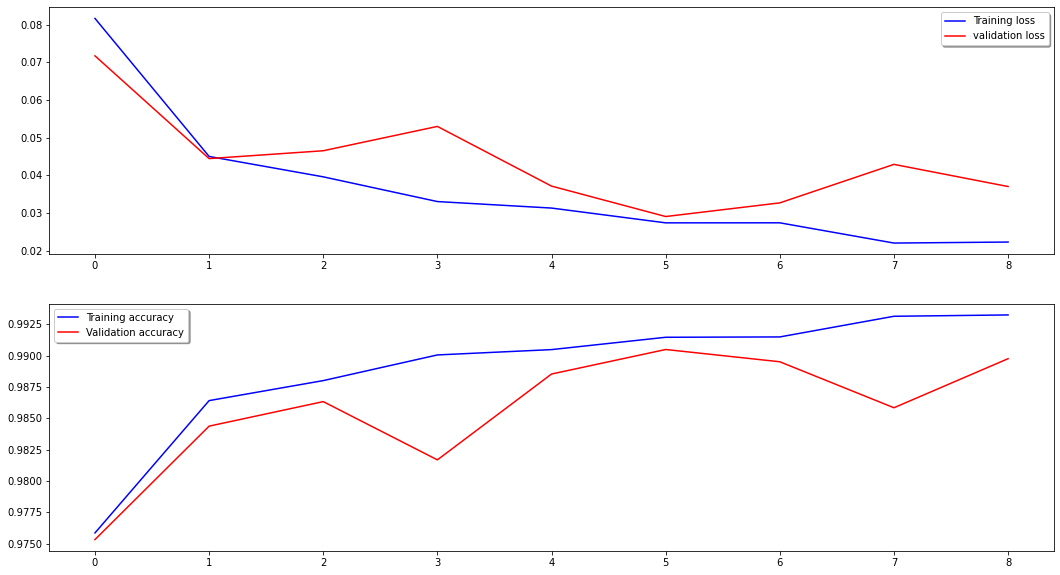

In [20]:
# Plot the loss and accuracy curves for training and validation 

fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)